In [11]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt

In [12]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 5000, max_height = 48/28):
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
        
    return freq

In [13]:
input_weight = 1e-2
spectral_radius = 0.9
regularization = 1e-5
average_degree = 3
leakage = 0
forgets = np.array([1,0.995,0.99,0.985,0.98])
# forgets = np.array([0.9825])
inv_forgets = 1/forgets
print(forgets)
data_seed = 30
cumulative = False
w_LM_reg = True
approx_LM_reg = True
LM_regs = np.array([1e-8])

step = 0.05
transient_length = int(50/step)
data_length = int(3000/step)
train_length = int(200/step)
start_length = int(50/step)
predict_length = int(20/step)
predict_gap_length = int(5/step)
num_predictions = 100
num_trials = 50
num_forgets = forgets.shape[0]
approx_num_nodes = 300

[1.    0.995 0.99  0.985 0.98 ]


In [14]:
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)

input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size);

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;

predictions = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times = np.zeros((num_predictions,num_trials,num_forgets))
wouts = np.zeros((input_size,num_nodes,num_predictions,num_trials,num_forgets))
times = np.zeros(num_predictions)

predictions_norm = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors_norm = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times_norm = np.zeros((num_predictions,num_trials,num_forgets))
wouts_norm = np.zeros((input_size,num_nodes,num_predictions,num_trials,num_forgets))

plot_itr = 50;
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_cosine,dxdt_lorenz,tau = 0.05)
    for k in range(num_forgets):
        for LM_reg in LM_regs:
            times = np.zeros(num_predictions)

            x = np.zeros(num_nodes)
            states = np.zeros((num_nodes, start_length))

            for t in range(transient_length):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)

            states[:,0] = x;

            for t in range(start_length-1):
                states[:,t+1] = advanceReservoir(win,A_mat,states[:,t],\
                        train_input_sequence[:,t+transient_length],leakage)

            x = states[:,-1]

            aug_states = np.copy(states)
            aug_states[::2,:] = np.power(states[::2,:],2)
            idenmat = regularization*sparse.identity(num_nodes)
            s_mat = np.diag(np.power(forgets[k],np.arange(start_length)[::-1]))
            data_trstates = np.matmul(np.matmul(train_input_sequence[:,transient_length:transient_length+start_length],\
                                                s_mat),\
                                      np.transpose(aug_states))
            states_trstates = np.matmul(np.matmul(aug_states,s_mat),np.transpose(aug_states))
            states_trstates_inv = pinv(states_trstates + idenmat)
            wout = np.matmul(data_trstates,states_trstates_inv)

            wout_norm = np.copy(wout)
            x_norm = np.copy(x)

            error_cutoff = 1;
            if w_LM_reg:
                LM_idenmat = sparse.identity(num_nodes)
            for pred in range(num_predictions):
                predictions[:,:,pred,data_seed,k] = getPrediction(win,A_mat,wout,x,predict_length,leakage)
                    
                start_pred_idx = transient_length + start_length + pred*predict_gap_length - 1
                times[pred] = start_pred_idx*step
                truths[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx :start_pred_idx + predict_length]
                # plt.plot(np.arange(predict_length)*step,truth[0,:],label = 'Truth')
                # plt.plot(np.arange(predict_length)*step,prediction[0,:],label = 'Reservoir w/ RLS')
                # plt.xlabel('Time')
                # plt.ylabel('x(t)')
                # tlfg = step*np.log(1/2)/np.log(forgets[k])
                # plt.title('$t_\lambda = %f$' % tlfg)
                # plt.legend()
                # plt.show()
                errors[:,pred,data_seed,k] = np.linalg.norm(predictions[:,:,pred,data_seed,k] - truths[:,:,pred,data_seed,k], axis = 0)/np.sqrt(np.mean(truths[:,:,pred,data_seed,k]**2))

                for i in range(predict_length):
                    if errors[i,pred,data_seed,k] > error_cutoff:
                        break
                    else:
                        valid_times[pred,data_seed,k] += 1

                for i in range(predict_gap_length):
                    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                    aug_x = np.copy(x)
                    aug_x[::2] = np.power(x[::2],2)
                    data_trstates = forgets[k]*data_trstates + \
                        np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)

                    states_trstates_inv = inv_forgets[k]*(states_trstates_inv - 1.0/\
                            (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv),aug_x))*\
                            np.outer(np.dot(states_trstates_inv,aug_x),np.dot(aug_x,states_trstates_inv))\
                            *inv_forgets[k])
                    if w_LM_reg:
                        if approx_LM_reg:
                            states_trstates_inv = states_trstates_inv - \
                                LM_reg*np.matmul(states_trstates_inv,states_trstates_inv)
                        else:
                            states_trstates_inv = np.transpose(solve(np.transpose(LM_reg*states_trstates_inv + \
                                LM_idenmat),np.transpose(states_trstates_inv)))



                wout = np.matmul(data_trstates,states_trstates_inv)
                # np.savetxt('Lorenz63Data/lorenz_prediction_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),prediction,delimiter = ',')
                # np.savetxt('Lorenz63Data/lorenz_error_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),error,delimiter = ',')
                # if k == 0 and LM_reg == LM_regs[0]:
                    # np.savetxt('Lorenz63Data/lorenz_truth_seed%d_pred%d.csv' % (data_seed,pred),truth,delimiter = ',')
            print(data_seed, k, LM_reg)
            # np.savetxt('Lorenz63Data/lorenz_valid_times_period_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),valid_time,delimiter = ',')
    
    """
        # print(k, data_seed)
        # print(valid_times)

        if cumulative:
            for pred in range(num_predictions):
                wouts_norm[:,:,pred,data_seed,k] = wout_norm
                predictions_norm[:,:,pred,data_seed,k] = getPrediction(win,A_mat,wout_norm,x_norm,predict_length,leakage)
                start_pred_idx = transient_length + start_length + pred*predict_gap_length - 1
                errors_norm[:,pred,data_seed,k] = np.linalg.norm(predictions_norm[:,:,pred,data_seed,k] - \
                                                               truths[:,:,pred,data_seed,k], axis = 0)/\
                                                np.sqrt(np.mean(truths[:,:,pred,data_seed,k]**2))

                for i in range(predict_length):
                    if errors_norm[i,pred,data_seed,k] > error_cutoff:
                        break
                    else:
                        valid_times_norm[pred,data_seed,k] += 1

                new_states = np.zeros((num_nodes,predict_gap_length))
                for i in range(predict_gap_length):
                    x_norm = advanceReservoir(win,A_mat,x_norm,train_input_sequence[:,start_pred_idx + i],leakage)
                    new_states[:,i] = x_norm

                new_aug_states = np.copy(new_states)
                new_aug_states[::2,:] = np.power(new_states[::2,:],2)
                aug_states = np.concatenate((aug_states,new_aug_states),axis = 1)
                s_mat = np.diag(np.power(forgets[k],np.arange(aug_states.shape[1])[::-1]))
                data_trstates = np.matmul(np.matmul(train_input_sequence[:,\
                                                                         transient_length:start_pred_idx + predict_gap_length + 1],\
                                                s_mat),\
                                      np.transpose(aug_states))
                states_trstates = np.matmul(np.matmul(aug_states,s_mat),np.transpose(aug_states))

                wout_norm = np.transpose(solve(np.transpose(states_trstates + idenmat),np.transpose(data_trstates)))


            # print(valid_times_norm)
    """

0 0 1e-08
0 1 1e-08
0 2 1e-08
0 3 1e-08
0 4 1e-08
1 0 1e-08
1 1 1e-08
1 2 1e-08
1 3 1e-08
1 4 1e-08
2 0 1e-08
2 1 1e-08
2 2 1e-08
2 3 1e-08
2 4 1e-08
3 0 1e-08
3 1 1e-08
3 2 1e-08
3 3 1e-08
3 4 1e-08
4 0 1e-08
4 1 1e-08
4 2 1e-08
4 3 1e-08
4 4 1e-08
5 0 1e-08
5 1 1e-08
5 2 1e-08
5 3 1e-08
5 4 1e-08
6 0 1e-08
6 1 1e-08
6 2 1e-08
6 3 1e-08
6 4 1e-08
7 0 1e-08
7 1 1e-08
7 2 1e-08
7 3 1e-08
7 4 1e-08
8 0 1e-08
8 1 1e-08
8 2 1e-08
8 3 1e-08
8 4 1e-08
9 0 1e-08
9 1 1e-08
9 2 1e-08
9 3 1e-08
9 4 1e-08
10 0 1e-08
10 1 1e-08
10 2 1e-08
10 3 1e-08
10 4 1e-08
11 0 1e-08
11 1 1e-08
11 2 1e-08
11 3 1e-08
11 4 1e-08
12 0 1e-08
12 1 1e-08
12 2 1e-08
12 3 1e-08
12 4 1e-08
13 0 1e-08
13 1 1e-08
13 2 1e-08
13 3 1e-08
13 4 1e-08
14 0 1e-08
14 1 1e-08
14 2 1e-08
14 3 1e-08
14 4 1e-08
15 0 1e-08
15 1 1e-08
15 2 1e-08
15 3 1e-08
15 4 1e-08
16 0 1e-08
16 1 1e-08
16 2 1e-08
16 3 1e-08
16 4 1e-08
17 0 1e-08
17 1 1e-08
17 2 1e-08
17 3 1e-08
17 4 1e-08
18 0 1e-08
18 1 1e-08
18 2 1e-08
18 3 1e-08
18 4 1e-08
19 0 

In [55]:
best_valid_times = np.zeros((3,num_predictions))
max_avg_valid_times = np.zeros(num_predictions)
for k in range(num_forgets):
    for LM_reg in LM_regs:
        new_avg_valid_times = np.zeros(num_predictions)
        for data_seed in range(num_trials):
            new_avg_valid_times = new_avg_valid_times + np.loadtxt('Lorenz63Data/lorenz_valid_times_period2000_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),delimiter = ',')
        new_avg_valid_times = new_avg_valid_times/num_trials
        max_avg_valid_times = np.maximum(max_avg_valid_times,new_avg_valid_times)
        for pred in range(num_predictions):
            if max_avg_valid_times[pred] == new_avg_valid_times[pred]:
                best_valid_times[0,pred] = data_seed
                best_valid_times[1,pred] = forgets[k]
                best_valid_times[2,pred] = LM_reg

In [59]:
# print(best_valid_times)


{0.9925: 6, 0.9875: 4, 0.9825: 16, 0.98: 54, 0.985: 4, 0.99: 4, 0.995: 12}


In [ ]:
wouts_abs = np.sqrt(np.mean((wouts - wouts_norm)**2,axis = (0,1)))
plt.plot(wouts_abs)
plt.show()

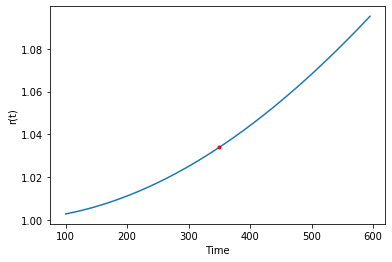

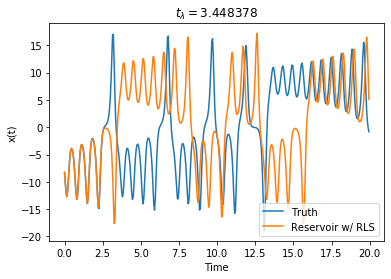

In [21]:
itr = 50
run = 15
fg  = 2
times_all = step*(transient_length + start_length + np.arange(num_predictions)*predict_gap_length)
plt.plot(times_all,r_t_cosine(times))
plt.plot(times[itr],r_t_cosine(times[itr]),'r.')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.savefig('r_t_cosine_period5000_itr%d_run%d_forget%d.pdf' % (itr,run,fg))
plt.show()
plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fg],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fg],label = 'Reservoir w/ RLS')
plt.xlabel('Time')
plt.ylabel('x(t)')
tlfg = step*np.log(1/2)/np.log(forgets[fg])
plt.title('$t_\lambda = %f$' % tlfg)
plt.legend()
plt.savefig('x_t_truth_vs_pred_period5000_itr%d_run%d_forget%d_reg1e-8_wapproxLMreg.pdf' % (itr,run,fg))
plt.show()

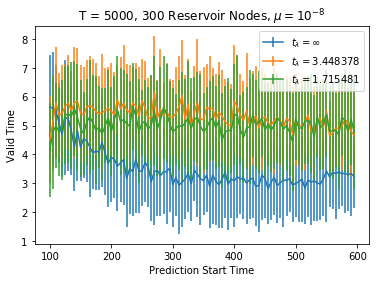

In [19]:
idx1 = 2
tl1 = step*np.log(1/2)/np.log(forgets[idx1])
idx2 = 4
tl2 = step*np.log(1/2)/np.log(forgets[idx2])
plt.errorbar(times,np.mean(valid_times[:,:,0],axis = 1)*step,step*np.std(valid_times[:,:,0],axis = 1),label = '$t_\lambda = \infty$')
plt.errorbar(times,np.mean(valid_times[:,:,idx1],axis = 1)*step,step*np.std(valid_times[:,:,idx1],axis = 1),label = '$t_\lambda = %f$' % tl1)
plt.errorbar(times,np.mean(valid_times[:,:,idx2],axis = 1)*step,step*np.std(valid_times[:,:,idx2],axis = 1),label = '$t_\lambda = %f$' % tl2)
plt.legend()
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('T = 5000, 300 Reservoir Nodes, $\mu = 10^{-8}$')
plt.savefig('valid_time_vs_start_time_period5000_reg1e-8_wapproxLMreg.pdf')
plt.show()

In [ ]:
plt.plot(predictions[0,:,80,5,6])
plt.plot(truths[0,:,80,5,6])
plt.show()